# Age Estimation using VGG16

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import load_model

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.utils import shuffle

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

%matplotlib inline

from PIL import Image
import shutil

## Age estimation in age groups

### Set image size and variables 

In [3]:
IMAGE_SIZE = [224,224]
TRAIN_TEST_SPLIT = 0.3
BASE_DIR = '../input/utkface-new/UTKFace/'
NR_EPOCHS = 60

### Define methods map direct age to classes

In [4]:
def age_to_class( age ):
    age_class = None
    if 0 <= age <= 20:
        age_class = 0
    if 20 < age <= 25:
        age_class = 1
    if 25 < age <= 30:
        age_class = 2
    if 30 < age <= 40:
        age_class = 3
    if 40 < age <= 60:
        age_class = 4
    if age > 60:
        age_class = 5
    return age_class

age_dict = {0:'0-20', 1:'20-25',2:'25-30', 3:'30-40', 4:'40-60', 5:'60+'}

def decode_age_label(age_id):
    return age_dict[int(age_id)]

### Read input dataset

In [5]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []

for filename in tqdm(os.listdir(BASE_DIR)):
  #read image path
  image_path = os.path.join(BASE_DIR, filename)
  #split filename to extract labels
  temp= filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

# extract name of file 
names = []
for path in image_paths:
  temp = path.split('/')
  names.append(temp[4])

#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['age_class'], df['name'] = image_paths, age_labels, gender_labels, age_class, names
df.head()
df

# get and print the number of images in dataframe
age_verbose = [age_dict[int(age)] for age in df['age_class']]

print(Counter(age_verbose))



  0%|          | 0/23708 [00:00<?, ?it/s]

Counter({'25-30': 5024, '0-20': 4877, '30-40': 4339, '40-60': 4311, '20-25': 2760, '60+': 2397})


### Shuffle dataset

In [6]:
# shuffle dataset 
df = shuffle(df)

In [7]:
# check dataframe
df 

,image,age,gender,age_class,name
22793,../input/utkface-new/UTKFace/36_0_2_2017010420...,36,0,3,36_0_2_20170104200528385.jpg.chip.jpg
14052,../input/utkface-new/UTKFace/31_1_1_2017011221...,31,1,3,31_1_1_20170112210802028.jpg.chip.jpg
6921,../input/utkface-new/UTKFace/4_0_2_20161219141...,4,0,0,4_0_2_20161219141410544.jpg.chip.jpg
21610,../input/utkface-new/UTKFace/27_0_1_2017011701...,27,0,2,27_0_1_20170117012341879.jpg.chip.jpg
7452,../input/utkface-new/UTKFace/29_1_0_2017012014...,29,1,2,29_1_0_20170120140336809.jpg.chip.jpg
...,...,...,...,...,...
13805,../input/utkface-new/UTKFace/1_0_0_20170110213...,1,0,0,1_0_0_20170110213042127.jpg.chip.jpg
1465,../input/utkface-new/UTKFace/27_1_2_2017011617...,27,1,2,27_1_2_20170116172655057.jpg.chip.jpg
2400,../input/utkface-new/UTKFace/56_1_0_2017010316...,56,1,4,56_1_0_20170103162933143.jpg.chip.jpg
17416,../input/utkface-new/UTKFace/43_0_1_2017011620...,43,0,4,43_0_1_20170116203818122.jpg.chip.jpg


### Split Dataset into validation and test set  

In [8]:
training_data = df.sample(frac=0.8, random_state=25)
temp = df.drop(training_data.index)


val_data =  temp.sample(frac=0.7, random_state=25)
testing_data = temp.drop(val_data.index)

 
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of training examples: {val_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")


No. of training examples: 18966
No. of training examples: 3319
No. of testing examples: 1423


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)


CLASS_MODE = 'raw'
BATCH_SIZE = 64
BASE_DIR = '../input/utkface-new/UTKFace'

train_generator = train_datagen.flow_from_dataframe(dataframe=training_data, 
                                                directory=BASE_DIR, 
                                                x_col='name', 
                                                y_col='gender', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)



val_generator = val_datagen.flow_from_dataframe(dataframe=val_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='gender', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)

test_generator = val_datagen.flow_from_dataframe(dataframe=testing_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='gender', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)


Found 18966 validated image filenames.
Found 3319 validated image filenames.
Found 1423 validated image filenames.


In [10]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


MODEL_PATH = "./models/age_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/age_model_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)



2022-12-15 01:58:21.263043: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-15 01:58:21.263082: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-15 01:58:21.343124: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-15 01:58:21.384336: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-15 01:58:21.384539: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


### Build and load Model

In [11]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [12]:
# load VGG16 without the last 3 Dense layers, in order to train these new
r50 = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# check if input type is correct
r50.inputs

2022-12-15 01:58:21.628397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 01:58:21.753260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 01:58:21.754385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 01:58:21.759428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]

In [13]:
from keras.layers import *
for layer in r50.layers:
  layer.trainable = False


x = Flatten()(r50.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=r50.input, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(train_generator,
                    epochs=NR_EPOCHS,
                    validation_data=val_generator,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-15 01:58:27.188883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-12-15 01:58:31.110443: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/297 [..............................] - ETA: 47:34 - loss: 0.6805 - sparse_categorical_accuracy: 0.5938

2022-12-15 01:58:36.958032: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-15 01:58:36.958077: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/297 [..............................] - ETA: 2:52 - loss: 113.6956 - sparse_categorical_accuracy: 0.5703

2022-12-15 01:58:37.459337: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-15 01:58:37.460166: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-15 01:58:37.606587: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 407 callback api events and 404 activity events. 
2022-12-15 01:58:37.621423: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-15 01:58:37.644793: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37

2022-12-15 01:58:37.653446: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37/430b23f62040.trace.json.gz


  3/297 [..............................] - ETA: 2:29 - loss: 76.3662 - sparse_categorical_accuracy: 0.5469 

2022-12-15 01:58:37.724311: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37

2022-12-15 01:58:37.730607: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37/430b23f62040.memory_profile.json.gz
2022-12-15 01:58:37.732029: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37
Dumped tool data for xplane.pb to ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37/430b23f62040.xplane.pb
Dumped tool data for overview_page.pb to ../tblogs/age_model_22-12-15_01-58/train/plugins/profile/2022_12_15_01_58_37/430b23f62040.overview_page.pb
Dumped tool data for input_pipeline.pb to ../tblogs/age_model_22-12-15_01-58/train/plugins/

297/297 [==============================] - 146s 461ms/step - loss: 1.7614 - sparse_categorical_accuracy: 0.5171 - val_loss: 0.7005 - val_sparse_categorical_accuracy: 0.5363

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.53631, saving model to ./models/age_best_model.h5


2022-12-15 02:00:53.749842: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.
2022-12-15 02:00:58.040282: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.
2022-12-15 02:01:01.882799: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.


Epoch 2/60
297/297 [==============================] - 129s 434ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.5207 - val_loss: 0.6905 - val_sparse_categorical_accuracy: 0.5363

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.53631
Epoch 3/60
297/297 [==============================] - 80s 267ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5204 - val_loss: 0.6909 - val_sparse_categorical_accuracy: 0.5363

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.53631
Epoch 4/60
297/297 [==============================] - 86s 289ms/step - loss: 0.6924 - sparse_categorical_accuracy: 0.5204 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.5363

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.53631
Epoch 5/60
297/297 [==============================] - 86s 288ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5204 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.5363

Epoch 00005: val_sparse_categorical_accur

### Plot Training and Validation Loss

In [15]:
# print keys 
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

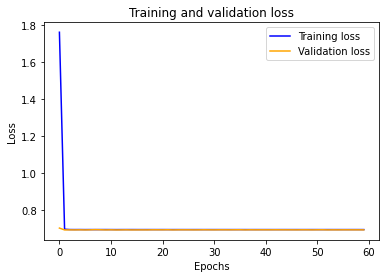

In [16]:
NR_EPOCHS = len(history.history['loss'])
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

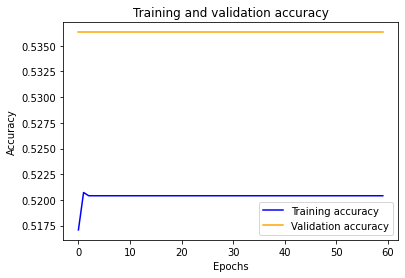

In [17]:
accuracy_train = history.history['sparse_categorical_accuracy']
accuracy_val = history.history['val_sparse_categorical_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, accuracy_train, 'b', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load model and validate

In [18]:
model_age = load_model("./models/age_best_model.h5")
loss, acc = model_age.evaluate(test_generator)
print (loss, acc)

2022-12-15 03:25:04.220105: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.
2022-12-15 03:25:06.195186: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.


23/23 [==============================] - 11s 434ms/step - loss: 0.7070 - sparse_categorical_accuracy: 0.5207
0.707047700881958 0.5207308530807495


### Show sample results

In [19]:
gen_dict = {0:'0', 1:'1'}

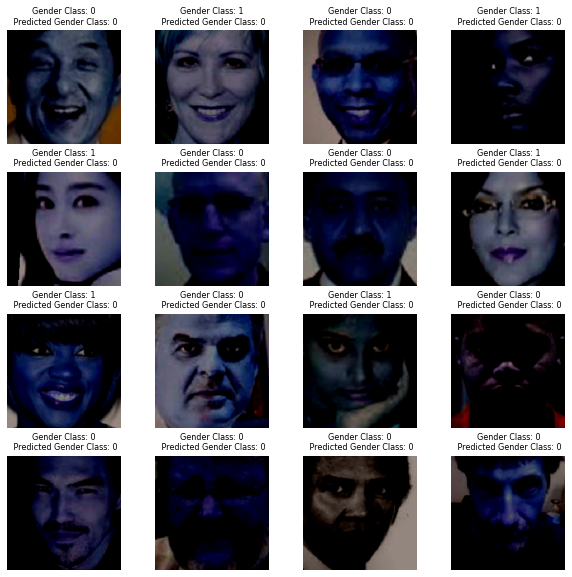

In [20]:
def show_faces(images, age=None, pred_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [pred_age, age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.axis('off')
        #plt.xticks([])
        #plt.yticks([])
        #plt.grid(False)
        plt.imshow(images[i])
        
        if pred_age[i] is None:
            continue
           
            
        real_age = int(age[i])
        predicted_age = np.argmax(predicted[i])
                
                
        plt.title(f"Gender Class: {gen_dict[real_age]}\n Predicted Gender Class: {gen_dict[predicted_age]}", fontsize=8)
            
        plt.subplots_adjust(wspace=0.3)

sample_validation_images, sample_validation_labels = next(test_generator)
predicted = model_age.predict(sample_validation_images)
show_faces(sample_validation_images, age=sample_validation_labels, pred_age=predicted)

(array([[0.60351837, 0.3964817 ]], dtype=float32), 60.3518, 0)


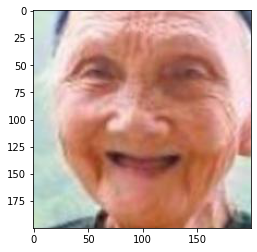

In [32]:
def predictor(filename) :
    test_image = filename
    image_result = Image.open(test_image)
    # test_image = image.load_img(test_image, target_size=(100,100))
    test_image = image.load_img(test_image, target_size=(224,224,3))
    test_image = image.img_to_array(test_image)
    test_image = test_image/255
    test_image = np.expand_dims(test_image, axis=0)
    result = model_age.predict(test_image)
    r = np.max(result)
    per = r*100
    percentage = round(per,4)
    categories = [1,1]
    image_result = plt.imshow(image_result)
    output = categories[np.argmax(result)]
    output = np.argmax(result)

    return result,percentage,output
EMOTION_DETECTOR = predictor('/kaggle/input/utkface-new/UTKFace/101_1_2_20170105174739309.jpg.chip.jpg')
print(EMOTION_DETECTOR)

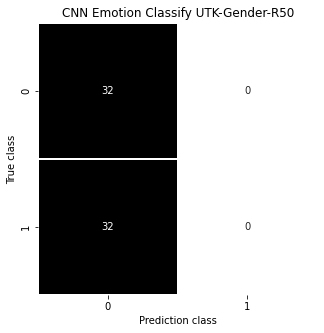

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
sample_validation_images, sample_validation_labels = next(test_generator)
predict_x=model_age.predict(sample_validation_images) 
results=np.argmax(predict_x,axis=1)
cm = confusion_matrix(sample_validation_labels, results)
cm_plot_labels = ['0','1']

cm_df = pd.DataFrame(cm, index = cm_plot_labels,
                     columns = cm_plot_labels
                    )
final_cm = cm_df
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify UTK-Gender-R50')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [23]:
print('\t\tClassification Report For UTK-Gender-R50\n', classification_report(sample_validation_labels, results,target_names=cm_plot_labels))


		Classification Report For UTK-Gender-R50
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        32
           1       0.00      0.00      0.00        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import sys

sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]'